##### Joshua Fisher
##### Project Deliverable 2

#### Dataset & Business Use Case Version 2

> In the late 1990’s, the NHL started their initiative to track player and team statistics on a game-by-game basis. However, it was not until this past decade that sports analytics came into the forefront as a tool to measure player performance. Teams around the league have established analytics teams to track and model a multitude of stats in order evaluate what make a player good and therefore what wins hockey games. While the main goal is of course to win a Stanley Cup championship, the NHL is a business and thus focused on maximizing profits. In recent seasons, the NHL has made about 5 billion dollars in yearly revenue. Each team on average is valued at around 650 million dollars. The main production of revenue is driven by ticket sales and television contracts. More successful teams in larger markets are rewarded by more ticket sales and television primetime slots. Next season, the Seattle Kraken will be entering the league as the 32nd NHL team. With the expansion draft coming up, it is key that the team identifies who the key players are, for good players win hockey games and therefore increase revenue.  This will be achieved using a collection of NHL datasets that capture a season’s worth of game and player statistics. The repository can be found at: https://www.kaggle.com/martinellis/nhl-game-data

> Using techniques common to graph theory and network science, this use case will aim to answer the question: “Which players are most central to hockey games?” Answering this question will identify who the best players are in the league and provide the most value to their teams.  In doing so, the Seattle Kraken will be able to draft the best players available to win a Stanley Cup and optimize their organization. 


#### Data Model Version 2
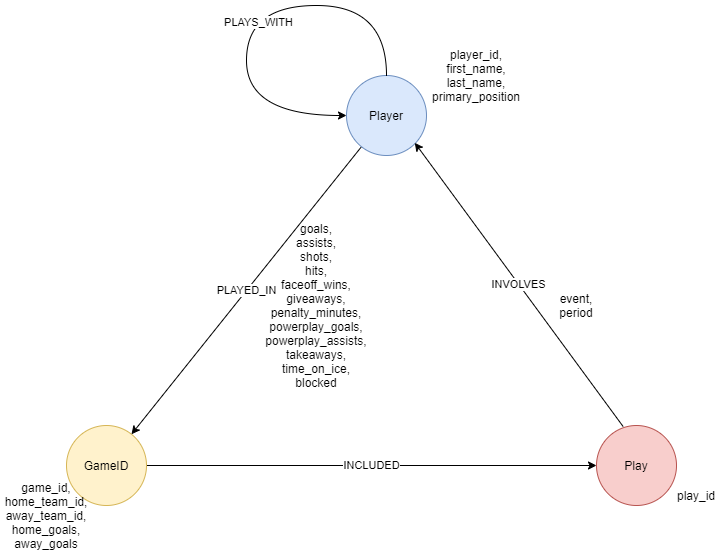

#### Data Model Update Reasoning

> Data model version 2 is quite different than the original design. After a lot of data manipulation and brain storming, the focus of this data moving forward will be on the "Plays" and the interactions between players. Originally, it was believed that the game stats (goals, assists, etc) were the central source of value. This was not the case. In this data model version 2, the game stats were moved to edge properties. Additionally, the play characteristics "event" and "period" were also defined as edge properties. By doing so, cypher queries can be written to filter based on these stats and then algorithms can be applied to the important nodes like Player and Play. 

#### Projections

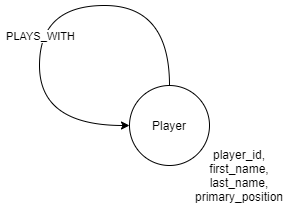


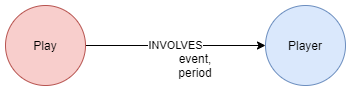

#### Populated Neo4J Database Screenshot

<img src="Populated Neo4J Database Pic.png">

In [1]:
import pandas as pd

### Cypher Queries

#### Cypher Query 1

MATCH (p:Player) <br>
WITH p, SIZE((p)<-[:PLAYS_WITH]-()) AS plays_with_degree <br>
RETURN p.first_name + ' ' + p.last_name AS name, plays_with_degree <br>
ORDER BY plays_with DESC <br>

In [5]:
plays_with = pd.read_csv('Cypher1_result.csv')
plays_with.head()

,name,plays_with_degree
0,Ryan Getzlaf,159
1,Claude Giroux,153
2,Jordan Staal,136
3,Derek Grant,129
4,Adam Henrique,128


This first query gives insight into which players have the most interactions with other players. A player who is playing with more people means that they are central to a network and likely to be important. These are nodes/players that can help to understand how the player network is structured and how are singificant players.

#### Cypher Query 2

MATCH (p:Player) <br>
WITH p, SIZE((p)<-[:INVOLVES]-()) as player_involvement <br>
RETURN p.first_name + ' ' + p.last_name, player_involvement <br>
ORDER BY player_involvement DESC <br>

In [7]:
player_involvement = pd.read_csv('Cypher2_result.csv')
player_involvement.head()

,name,player_involvement
0,Dylan Larkin,629
1,Patrice Bergeron,617
2,Bo Horvat,572
3,Mark Scheifele,571
4,Claude Giroux,570


Hockey players that are involved in more plays, thus contributing to the game, are believed to hold more value. Therefore, this query aimed to identify the players that were involved in the most plays. It returns first and last name of the player as well as the number of player involvements, defined by the number of degrees linked by an INVOLVES edge.


#### Cypher Query 3

MATCH (p:Player)-[n:INVOLVES]-() <br>
WHERE n.event IN ['Goal','Assist'] <br>
RETURN p.first_name + ' ' + p.last_name AS name, count(n.event) AS Degree <br>
ORDER BY Degree DESC

In [9]:
goals_assists_leaders = pd.read_csv('Cypher3_result.csv')
goals_assists_leaders.head()

,name,Degree
0,Leon Draisaitl,42
1,Connor McDavid,37
2,Brad Marchand,32
3,John Carlson,31
4,David Pastrnak,31


Goals and assists (which are indirectly goals) are the most valued stat in a hockey game. In order to win games, you need to score more goals than the opposing teams. This query returns players who were involved in the most plays in which the INVOLVES edge property was either a goal or an assist as well as the count of event that met that criteria. 

#### Cypher Query 4

MATCH (p1:Player)-[i1:INVOLVES]-(pl:Play)-[i2:INVOLVES]-(p2:Player) <br>
WHERE i1.event IN ['Faceoff'] AND  <br>
&emsp;&emsp;&emsp; i2.event IN ['Faceoff'] AND <br>
&emsp;&emsp;&emsp; id(p1) < id(p2)<br>
RETURN DISTINCT p1.first_name + ' ' + p1.last_name AS first_player, <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; p2.first_name + ' ' + p2.last_name AS second_player, <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; COUNT(pl) AS faceoffs_together_count <br>
ORDER BY faceoffs_together_count DESC <br>

In [17]:
faceoffs = pd.read_csv('Cypher4_faceoffs.csv')
faceoffs.head()

,first_player,second_player,faceoffs_together_count
0,Brock Nelson,Aleksander Barkov,29
1,Auston Matthews,Patrice Bergeron,27
2,Anthony Cirelli,Aleksander Barkov,25
3,Mark Scheifele,Sidney Crosby,25
4,Jack Eichel,Anthony Cirelli,22


Faceoffs are a major part of every hockey game. Simply put, winning a faceoffs gives your team posssesion of the puck. Possession of the puck is needed to score goals and thus win the game. Above is a query that finds the players that have engaged in the most faceoffs together. Using this knowledge in conjunction with the player statistics, advantageous matchups can be identified. For example, two players from above, Auston Matthews and Patrice Bergeron, both play in the Atlantic Division. If I can find that Patrice Bergeron wins 75% of faceoffs against Auston Matthews, the Boston coach should be aware that Bergeron is likely to win and so he should be put out on the ice when Auston Matthews is also on the ice. 

### Algorithm 1 - PageRank

#### Projection

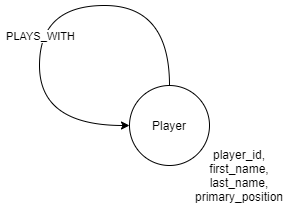

#### Code

CALL gds.graph.create.cypher('plays_with_graph', <br>
                     'MATCH (p:Player) RETURN id(p) as id', <br>
                     'MATCH (p1:Player)-[:PLAYS_WITH]-(p2:Player) RETURN id(p1) as source, id(p2) as target'); <br>
                     
CALL gds.pageRank.stream('plays_with_graph') YIELD nodeId, score <br>
RETURN gds.util.asNode(nodeId).first_name + ' ' + gds.util.asNode(nodeId).last_name AS name, score <br>
ORDER BY score DESC LIMIT 10 <br>

#### Results

In [26]:
pageRank = pd.read_csv('page_rank_results.csv')

In [25]:
pageRank.head()

,name,score
0,Ryan Getzlaf,1.983806
1,Radek Faksa,1.974747
2,Jordan Staal,1.921278
3,Lars Eller,1.920954
4,Claude Giroux,1.884007


#### Conclusions

The idea behind using the PageRank algorithm for this use case was it's ability to find which players are most important to the network. This algorithm models the probability that random hops across the network would lead you to a certain player. The higher the score the more prominent a player. The results above displays the top 10 players ranked by PageRank score. Here we can see that players Ryan Getzlaf, Radek Faksa, and Jordan Staal are some of the most important players to this network. Knowing this information, we can conclude that these are players that should be targeted by the Seattle Kraken for the expansion draft.

### Algorithm 2 - Betweenness Centrality

#### Projection

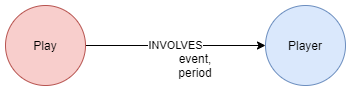

#### Code

CALL gds.graph.create.cypher('goal_assists', <br>
&emsp;&emsp;    'MATCH (p:Player) RETURN id(p) AS id', <br>
&emsp;&emsp;    'MATCH (p1:Player)-[i1:INVOLVES]-(pl:Play)-[i2:INVOLVES]-(p2:Player) <br>
&emsp;&emsp;     WHERE i1.event IN ["Goal","Assist"] AND i2.event IN ["Goal","Assist"] AND id(p1) < id(p2) <br>
&emsp;&emsp;     RETURN DISTINCT id(p1) AS source, id(p2) AS target'); <br>


CALL gds.betweenness.stream('goal_assists') YIELD nodeId, score <br>
RETURN gds.util.asNode(nodeId).first_name + ' ' + gds.util.asNode(nodeId).last_name AS name, score <br>
ORDER BY score DESC <br>


#### Results

In [18]:
betweenness = pd.read_csv('betweeness_results.csv')
betweenness.head()

,name,score
0,William Karlsson,30.866667
1,Filip Chlapik,27.333333
2,Radek Faksa,27.083333
3,Robby Fabbri,26.200000
4,Jared McCann,25.916667


#### Conclusions

Betweenness Centrality is typically used to find the people with most influence in a network. This algorithm gives insight into how much information a particular node has passed through it compared to other nodes. In this query, the idea was to identify players in which plays involved them. Goals and assists are the most valuable statistic in the game of hockey and therefore the plays were limited to these events. We can identify that players like William Karlsson are significantly important to this Goals + Assists network, meaning that he is highly involved in these plays. As such, he would be a prime candidate to target by the Seattle Kraken for the expansion draft. 

### Algorithm 3 - Modularity Optimization

#### Projection

Because the business case revolves around identifying who best players are, the same projection was used for this algorithm. The meat of this dataset lies in the relationship of who played with who. Therefore, the projection is the same:

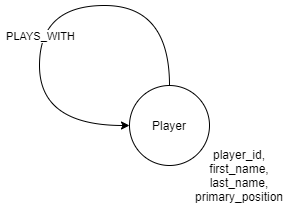

#### Code

CALL gds.graph.create.cypher('plays_with_graph', <br>
'MATCH (p:Player) RETURN id(p) as id', <br>
'MATCH (p1:Player)-[:PLAYS_WITH]-(p2:Player) RETURN id(p1) as source, id(p2) as target'); <br>


CALL gds.beta.modularityOptimization.stream('plays_with_graph') <br>
YIELD nodeId, communityId <br>
RETURN gds.util.asNode(nodeId).last_name as last_name, gds.util.asNode(nodeId).first_name as first_name, communityId <br>

#### Results

In [27]:
modularity = pd.read_csv('modularity_optimization.csv')

In [29]:
modularity.head()

,name,communityId
0,Shayne Gostisbehere,721
1,Claude Giroux,721
2,Travis Konecny,721
3,Ivan Provorov,721
4,Brandon Manning,416


#### Conclusions

The Modularity Optimization algorithm is a community detection technique used to find commmunities within a network. It is an extension of the Louvain algorithm. The modularity score evaluates the density and how well the groups have been assigned to their clusters or communities. The higher the modularity score, the more likely a node is to be long to that particular cluster. The idea behind using this algorithm for this use case lies in the fact that good players are most similar to other good players. So, if we are able to identify a "good player cluster" we can drill down to identify what players populate that cluster.  

The results above is a snippet of players and their communities that the algorithm assigned. Here we can see players who are similar to others. Using domain knowledge like knowing that "Claude Giroux" is a top player, we can deduce that players like "Travis Konecny" is also a good player. 

### Algorithm 4 - Degree Centrality

#### Projection

Again because the most important information is accessed using the PLAYS_WITH relationship, the same projection was used:

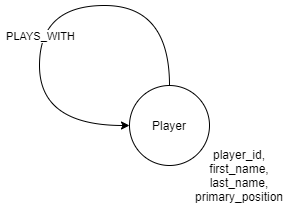

#### Code

CALL gds.graph.create.cypher('plays_with_graph', <br>
'MATCH (p:Player) RETURN id(p) as id', <br>
'MATCH (p1:Player)-[:PLAYS_WITH]-(p2:Player) RETURN id(p1) as source, id(p2) as target'); <br>


CALL gds.alpha.degree.stream('plays_with_graph') YIELD nodeId, score <br>
RETURN gds.util.asNode(nodeId).last_name As last_name, gds.util.asNode(nodeId).first_name AS first_name, score AS Degree <br>
ORDER BY score DESC

#### Results

In [31]:
degree = pd.read_csv('degree_centrality_results.csv')

In [34]:
degree.head()

,name,Degree
0,Ryan Getzlaf,163.0
1,Lars Eller,157.0
2,Jordan Staal,155.0
3,Claude Giroux,154.0
4,Radek Faksa,153.0


#### Conclusions

The degree centrality is a simple algorithm that is commonly used to find popular or important nodes. As such, this algorithm was applied to find the players who have the highest play degrees and thus involved in the most plays. Here was can see some re-occuring names from previous algorithm results like Ryan Getzlaf. This further supports that plays like him are valuable because of his high inter-connectedness. 